### Notes to self


### Set-up and Functions

In [1]:
#Run to install modules

#!pip install pyransac3d
#!pip install open3d
#!pip install easygui
#!pip install splines
#!pip install numpy-stl
#!pip install scipy
#!pip install matlablib
#!pip install scikit-learn

In [2]:
#Import the necessary modules

import numpy as np
import tkinter
from tkinter import filedialog
import pyransac3d as pyrsc
import random
from scipy.spatial import distance
from scipy import ndimage, misc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from sklearn.decomposition import PCA
import open3d as o3d
import easygui
import splines
import os

np.seterr(divide='ignore', invalid='ignore')


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
#Display inlier and outlier point clouds
def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

In [4]:
#Display two point cloud
def display_two_pointclouds(array_1,array_2,windowname):
    p1_pcd = o3d.geometry.PointCloud()
    p1_pcd.points = o3d.utility.Vector3dVector(array_1)
    p1_pcd.paint_uniform_color([1, 0.706, 0])


    p2_pcd = o3d.geometry.PointCloud()
    p2_pcd.points = o3d.utility.Vector3dVector(array_2)
    p2_pcd.paint_uniform_color([0, 0.706, 1])

    concate_pc = np.concatenate((array_1, array_2),axis = 0)
    p1_color = np.asarray(p1_pcd.colors)
    p2_color = np.asarray(p2_pcd.colors)
    p3_color = np.concatenate((p1_color,p2_color), axis=0)

    p3_pcd = o3d.geometry.PointCloud()
    p3_pcd.points = o3d.utility.Vector3dVector(concate_pc)
    p3_pcd.colors = o3d.utility.Vector3dVector(p3_color)
    o3d.visualization.draw_geometries([p3_pcd],window_name = windowname)

In [5]:
#Plot Quiver of Vectors 
def draw_geometries(pcds):
    """
    Draw Geometries
    Args:
        - pcds (): [pcd1,pcd2,...]
    """
    o3d.visualization.draw_geometries(pcds)

def get_o3d_FOR(origin=[0, 0, 0],size=10):
    """ 
    Create a FOR that can be added to the open3d point cloud
    """
    mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=size)
    mesh_frame.translate(origin)
    return(mesh_frame)

def vector_magnitude(vec):
    """
    Calculates a vector's magnitude.
    Args:
        - vec (): 
    """
    magnitude = np.sqrt(np.sum(vec**2))
    return(magnitude)


def calculate_zy_rotation_for_arrow(vec):
    """
    Calculates the rotations required to go from the vector vec to the 
    z axis vector of the original FOR. The first rotation that is 
    calculated is over the z axis. This will leave the vector vec on the
    XZ plane. Then, the rotation over the y axis. 

    Returns the angles of rotation over axis z and y required to
    get the vector vec into the same orientation as axis z
    of the original FOR

    Args:
        - vec (): 
    """
    # Rotation over z axis of the FOR
    gamma = np.arctan(vec[1]/vec[0])
    Rz = np.array([[np.cos(gamma),-np.sin(gamma),0],
                   [np.sin(gamma),np.cos(gamma),0],
                   [0,0,1]])
    # Rotate vec to calculate next rotation
    vec = Rz.T@vec.reshape(-1,1)
    vec = vec.reshape(-1)
    # Rotation over y axis of the FOR
    beta = np.arctan(vec[0]/vec[2])
    Ry = np.array([[np.cos(beta),0,np.sin(beta)],
                   [0,1,0],
                   [-np.sin(beta),0,np.cos(beta)]])
    return(Rz, Ry)

def create_arrow(scale=10):
    """
    Create an arrow in for Open3D
    """
    cone_height = scale*0.2
    cylinder_height = scale*0.8
    cone_radius = scale/10
    cylinder_radius = scale/20
    mesh_frame = o3d.geometry.TriangleMesh.create_arrow(cone_radius=1,
        cone_height=cone_height,
        cylinder_radius=0.5,
        cylinder_height=cylinder_height)
    return(mesh_frame)

def get_arrow(origin=[0, 0, 0], end=None, vec=None):
    """
    Creates an arrow from an origin point to an end point,
    or create an arrow from a vector vec starting from origin.
    Args:
        - end (): End point. [x,y,z]
        - vec (): Vector. [i,j,k]
    """
    scale = 10
    Ry = Rz = np.eye(3)
    T = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
    T[:3, -1] = origin
    if end is not None:
        vec = np.array(end) - np.array(origin)
    elif vec is not None:
        vec = np.array(vec)
    if end is not None or vec is not None:
        scale = vector_magnitude(vec)
        Rz, Ry = calculate_zy_rotation_for_arrow(vec)
    mesh = create_arrow(scale)
    # Create the arrow
    mesh.rotate(Ry, center=np.array([0, 0, 0]))
    mesh.rotate(Rz, center=np.array([0, 0, 0]))
    mesh.translate(origin)
    return(mesh)




https://stackoverflow.com/questions/1251438/catmull-rom-splines-in-python

In [6]:
def CatmullRomSpline(P0, P1, P2, P3, a, nPoints=10):
  """
  P0, P1, P2, and P3 should be (x,y) point pairs that define the Catmull-Rom spline.
  nPoints is the number of points to include in this curve segment.
  """
  # Convert the points to numpy so that we can do array multiplication
  #P0, P1, P2, P3 = map(numpy.array, [P0, P1, P2, P3])

  # Calculate t0 to t4
  alpha = a
  def tj(ti, Pi, Pj):
    xi, yi, zi = Pi
    xj, yj, zj = Pj
    return ( ( (xj-xi)**2 + (yj-yi)**2  + (zj-zi)**2 )**0.5 )**alpha + ti

  t0 = 0
  t1 = tj(t0, P0, P1)
  t2 = tj(t1, P1, P2)
  t3 = tj(t2, P2, P3)

  # Only calculate points between P1 and P2
  t = np.linspace(t1,t2,nPoints)

  # Reshape so that we can multiply by the points P0 to P3
  # and get a point for each value of t.
  t = t.reshape(len(t),1)

  A1 = (t1-t)/(t1-t0)*P0 + (t-t0)/(t1-t0)*P1
  A2 = (t2-t)/(t2-t1)*P1 + (t-t1)/(t2-t1)*P2
  A3 = (t3-t)/(t3-t2)*P2 + (t-t2)/(t3-t2)*P3

  B1 = (t2-t)/(t2-t0)*A1 + (t-t0)/(t2-t0)*A2
  B2 = (t3-t)/(t3-t1)*A2 + (t-t1)/(t3-t1)*A3

  C  = (t2-t)/(t2-t1)*B1 + (t-t1)/(t2-t1)*B2
  return C

def CatmullRomChain(P,alpha):
    """
    Calculate Catmull Rom for a chain of points and return the combined curve.
    """
    Points = P

    x1=Points[0][0]
    x2=Points[1][0]
    y1=Points[0][1]
    y2=Points[1][1]
    z1=Points[0][2]
    z2=Points[1][2]
    x3=Points[-2][0]
    x4=Points[-1][0]
    y3=Points[-2][1]
    y4=Points[-1][1]
    z3=Points[-2][2]
    z4=Points[-1][2]
    dom=max(Points[:,0])-min(Points[:,0])
    pctdom=1
    pctdom=float(pctdom)/100
    prex=x1+(np.sign(x1-x2)*dom*pctdom)
    prey=(y1-y2)/(x1-x2)*(prex-x1)+y1
    prez=(z1-z2)/(x1-x2)*(prex-x1)+z1
    endx=x4+np.sign(x4-x3)*dom*pctdom
    endy=((y4-y3)/(x4-x3)*(endx-x4))+y4
    endz=((z4-z3)/(x4-x3)*(endx-x4))+z4
    Points=list(Points)
    Points.insert(0,([prex,prey,prez]))
    Points.append(([endx,endy,endz]))
    sz = len(Points)

      # The curve C will contain an array of (x,y) points.
    C = []
    for i in range(sz-3):
        c = CatmullRomSpline(Points[i], Points[i+1], Points[i+2], Points[i+3],alpha)
        if ~np.isnan(c).any():      
            C.extend(c)

    return C, [[prex,prey,prez],[endx,endy,endz]]

In [7]:
def voxel_downsample_avg_radius(points_with_radius, voxel_size):
    #Seperate out points from radia
    points = points_with_radius[:,0:3]
    radia = points_with_radius[:,3]
    
    #Convert the points in to PointCloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    
    #Do the downsample
    pcd_ds = pcd.voxel_down_sample_and_trace(voxel_size, pcd.get_min_bound(), pcd.get_max_bound() )
    
    #Seperate out the trace matrix and PointCLoud
    trace = pcd_ds[1]
    pcd_ds = pcd_ds[0]
    
    new_points = np.asarray(pcd_ds.points)

    
    #Determine the new average radia
    new_radia = np.empty([0,1])
    
    for row in trace:
        avg = 0
        indicies = []
        for value in row:
            if value != -1:
                indicies = np.append(indicies,value)
        radia_pool = radia[indicies.astype(int)]
        avg = np.mean(radia_pool)
        new_radia = np.append(new_radia,avg)
        
        
    new_points_with_radia = np.append(new_points,np.transpose([new_radia]), axis=1)
    
    return new_points_with_radia

In [8]:
def true_averaging_filter(points_with_radius, number_points_to_average):

    k = number_points_to_average

    for i in range(0,2):
        #Get the nearest point array for the point pool
        distance_array = distance.squareform(distance.pdist(points_with_radius[:,0:3])) 
        closest_array = np.argsort(distance_array, axis=1) 

        avg_center = np.empty([0,4])
        num_points = np.shape(points_with_radius)

        #cycle through every point
        for index in range(0,num_points[0]):
            intial_point = points_with_radius[index]

            #now we need to find the nearest k neighbours to this point
            neighbour_points = np.array(intial_point, ndmin=2)
            closest_index=closest_array[index,1:k+1]
            for value in closest_index:
                neighbour_points = np.append(neighbour_points,[points_with_radius[value]],axis = 0)

            #now we average the coordinates of these points
            avg_point = np.mean(neighbour_points, axis = 0)
            avg_center = np.append(avg_center, [avg_point], axis = 0)


    return avg_center

In [9]:
def manual_filter(points_to_filter):
    flag = False

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_to_filter[:,0:3])
    pcd.paint_uniform_color([1, 0.706, 0])

    while flag != "True":
        # Visualize cloud and edit
        vis = o3d.visualization.VisualizerWithEditing()
        vis.create_window(window_name = 'Delect Data Points to Remove')
        vis.add_geometry(pcd)
        vis.add_geometry(mesh_frame)
        vis.run()
        vis.destroy_window()
        #print(vis.get_picked_points())

        pcd = pcd.select_by_index(vis.get_picked_points(),invert=True)
        filtered_points = np.asarray(pcd.points)
        display_two_pointclouds(point_cloud, filtered_points, 'Averaged Point Cloud')    

        flag = easygui.enterbox("Are you done filtering points? True or False")
        
    #Point cloud to point set with radius preserved

    passing_index = np.empty([0])
    filtered_points = np.asarray(pcd.points)

    for i in range(0, np.shape(filtered_points)[0]):
        index = np.where((points[:,0:3] == filtered_points[i,:]).all(axis=1))
        passing_index = np.append(passing_index,index)

    passing_index = np.int64(passing_index)
    points_new = points_to_filter[passing_index,:]
    
    return points_new


In [10]:
def modified_nearest_neighbour_array(points, index_of_point, number_nearest_neighbours):
    
    #Find nearest neighbour array for all points
    distance_array = distance.squareform(distance.pdist(points)) 
    closest_array = np.argsort(distance_array, axis=1) #get for each point a list of which points are closest
    
    intial_point = points[index_of_point,:]
    closest_index=closest_array[index_of_point,1]
    
    neighbour_points = np.array(intial_point, ndmin=2)
    index_history=np.array([index_of_point,closest_index] , ndmin=1)
    j=0
    #now we need to find the nearest k neighbours to this point
    
    while j < k:
        j = j+1    
        neighbour_points = np.append(neighbour_points,[points[closest_index,:]],axis = 0)

        #Now I want to find the nearest neighbour of the point we just append, 
        #but it needs to not be the same as the new point we just added
        i = 1 
        while closest_array[closest_index,i] in index_history:
            i = i + 1
        else: 
            closest_index = closest_array[closest_index,i]
        index_history = np.append(index_history,closest_index)
    
    return neighbour_points

In [11]:
def modified_nearest_neighbour_array_CRS(points, index_of_point, number_nearest_neighbours):
    
    #Find nearest neighbour array for all points
    distance_array = distance.squareform(distance.pdist(points)) 
    closest_array = np.argsort(distance_array, axis=1) #get for each point a list of which points are closest
    
    intial_point = points[index_of_point,:]
    closest_index=closest_array[index_of_point,1]
    
    neighbour_points = np.array(intial_point, ndmin=2)
    index_history=np.array([index_of_point,closest_index] , ndmin=1)
    j=0
    #now we need to find the nearest k neighbours to this point
    
    while j < k:
        j = j+1    
        neighbour_points = np.append(neighbour_points,points[closest_index,:],axis = 0)

        #Now I want to find the nearest neighbour of the point we just append, 
        #but it needs to not be the same as the new point we just added
        i = 1 
        new_index = closest_array[closest_index,i]
        while closest_array[closest_index,i] in index_history:
            i = i + 1
        else: 
            closest_index = closest_array[closest_index,i]
        index_history = np.append(index_history,closest_index)
    
    return neighbour_points

### Import Mesh File

In [12]:
#Import mesh file

tkinter.Tk().withdraw() # prevents an empty tkinter window from appearing
file_name = filedialog.askopenfilename()

In [13]:
#Imports the mesh and converts all vertices to points

with open(file_name) as file:
        file_contents = file.read() #import as string
        lines = file_contents.splitlines() #break into list by lines 
        
point_cloud = []

for line in lines:
    if 'vertex' in line:
        points = line.split(' ')
        point_cloud.append([float(points[1]),float(points[2]),float(points[3])]) 
        
point_cloud = np.array(point_cloud) 
point_cloud = np.unique(point_cloud, axis = 0) #remove duplicate points

In [14]:
#Display point cloud
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size = 10)
#Display point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud)
pcd.paint_uniform_color([1, 0.706, 0])
o3d.visualization.draw_geometries([pcd, mesh_frame],'Intial Point Cloud')

### Sphere Fitting

In [82]:
#Select percentage of the point cloud points at random to be fitted

eta = 0.75 #percentage of the points in the cloud we want to fit to 
k = 7 #the number of nearest neighbours we want to find
total_points = point_cloud.shape[0]

In [83]:
#Create a nearest neighbour point array

distance_array = distance.squareform(distance.pdist(point_cloud)) 
closest_array = np.argsort(distance_array, axis=1) #get for each point a list of which points are closest


https://stackoverflow.com/questions/20314306/find-arc-circle-equation-given-three-points-in-space-3d

In [84]:
#Do RANSAC fitting to a random portion of the points and save the center point and radius of each fitted sphere

examined_points = round(total_points*eta)
center_pool_raw = np.empty([0,4])

for i in range(0,examined_points): #will cycle through the determined number of points
    index = random.randint(0,total_points-1) #find the index number of a random starting point
    intial_point = point_cloud[index,:]
    
    #now we need to find the nearest k neighbours to this point
    neighbour_points = modified_nearest_neighbour_array(point_cloud, index, k)
    
    index_rand= random.sample(range(0,k),3)
    A = neighbour_points[index_rand[0],:]
    B = neighbour_points[index_rand[1],:]
    C = neighbour_points[index_rand[2],:]

    #Find vectors connecting the three points and the length of each vector
    AB = B - A 
    BC = C - B 
    AC = C - A 

    a = np.linalg.norm(C - B)
    b = np.linalg.norm(C - A)
    c = np.linalg.norm(B - A)
    
    s = (a + b + c) / 2
    R = a*b*c / 4 / np.sqrt(s * (s - a) * (s - b) * (s - c))
    b1 = a*a * (b*b + c*c - a*a)
    b2 = b*b * (a*a + c*c - b*b)
    b3 = c*c * (a*a + b*b - c*c)
    P = np.column_stack((A, B, C)).dot(np.hstack((b1, b2, b3)))
    P /= b1 + b2 + b3
    radius_cal = R
    center = P

    

    #Now we should we ready to fit the sphere to these sequence of points twice per point
    #for j in range(0,3):
        #sph = pyrsc.Sphere()
        #center, radius_cal, inliers = sph.fit(neighbour_points, thresh= 0.05)
        
        
    new_data = np.append(center, radius_cal)
    new_data=[new_data]
    try:
        center_pool_raw = np.append(center_pool_raw, new_data ,axis = 0)
    except:
        print(new_data)
        print(center)
        print(radius_cal)

points = center_pool_raw
points= points[~np.isnan(points).any(axis=1)]
points= points[~np.isinf(points).any(axis=1)]

### Filtering the Sphere Fitting Results

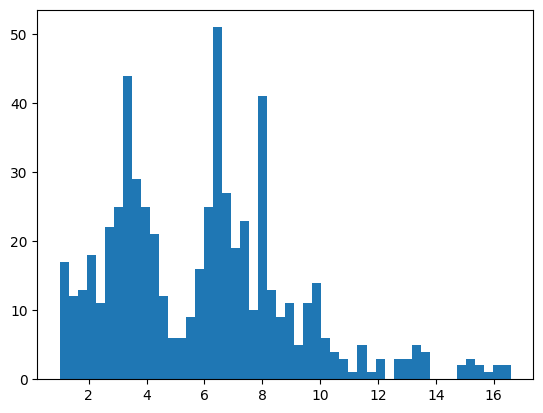

In [89]:
#Here we will do the radius filtering

num_points = np.shape(points)

#Check for points outside of the bounding box of the point cloud
removal_index = []
for index in range(0, num_points[0]):
    if points[index,0] > np.max(point_cloud[:,0]) or points[index,0] < np.min(point_cloud[:,0]):
        removal_index.append(index) 
    if points[index,1] > np.max(point_cloud[:,1]) or points[index,1] < np.min(point_cloud[:,1]):
        removal_index.append(index) 
    if points[index,2] > np.max(point_cloud[:,2]) or points[index,2] < np.min(point_cloud[:,2]):
        removal_index.append(index) 

filtered_points = np.delete(points, removal_index, axis = 0)
points=filtered_points
num_points = np.shape(points)

#print(np.median(points[:,3]))
#print(np.mean(points[:,3]))

##First we find the median radius 
#median_radius = np.mean(points[:,3])
#removal_index = []

#Now we go through for every point and if the radius is 0.33x or 1.3x different in size then we will disregard that point 
for index in range(0, num_points[0]):
    if points[index,3] < 1: #points[index,3] > 2*median_radius or 
        removal_index.append(index)  
    
filtered_points = np.delete(points, removal_index, axis = 0)

plt.hist(filtered_points[:,3], bins=50)
plt.show()

In [90]:
#Display point cloud
points=filtered_points
display_two_pointclouds(point_cloud,points[:,0:3], 'Point Cloud and Center Points')

In [92]:
#User decides if the want to apply filters
avg_filter = easygui.enterbox("Run true avg filter? True or False")

#Now an average filter
if avg_filter == "True":
    points = true_averaging_filter(points, 10)
        
    #Display point cloud
    display_two_pointclouds(point_cloud, points[:,0:3], 'Averaged Point Cloud')    

In [93]:
#User decides if the want to apply filters
avg_filter = easygui.enterbox("Run voxel avg filter? True or False")

#Now an average filter
if avg_filter == "True":
    points = voxel_downsample_avg_radius(points, 10)
        
    #Display point cloud
    display_two_pointclouds(point_cloud, points[:,0:3], 'Averaged Point Cloud')    

In [94]:
#Rounds a remove very similiar points to ease manual filtering 

#Round the data points to one decimal place and filter out the only unique values. 
rounded= np.round(points[:,0:3],decimals = 0)
unique, indices = np.unique(rounded, axis=0,return_index=True)
rounded = rounded[indices,:]

#Added back on the radii 
radii = np.transpose([points[indices, 3]])
rounded = np.append(rounded , radii, axis = 1)


In [95]:
#Update the final data point set
points = rounded

In [96]:
#Select from the visualization points to remove, iterate to remove all points
filtered_points = manual_filter(points)

[Open3D INFO] Picked point #14 (-16., 8.0, 2.2e+02) to add in queue.
[Open3D INFO] No point has been picked.
[Open3D INFO] No point has been picked.
[Open3D INFO] Picked point #1 (-25., 16., 1.5e+02) to add in queue.
[Open3D INFO] No point has been picked.
[Open3D INFO] Picked point #0 (-27., 8.0, 1.3e+02) to add in queue.
[Open3D INFO] Picked point #5 (-22., 4.0, 1.2e+02) to add in queue.
[Open3D INFO] Picked point #8 (-19., 1.0, 99.) to add in queue.
[Open3D INFO] No point has been picked.
[Open3D INFO] Picked point #20 (-12., -2.0, 81.) to add in queue.
[Open3D INFO] Picked point #23 (-9.0, -7.0, 63.) to add in queue.
[Open3D INFO] Picked point #25 (-7.0, -8.0, 44.) to add in queue.
[Open3D INFO] No point has been picked.
[Open3D INFO] Picked point #14 (-13., 15., 1.2e+02) to add in queue.
[Open3D INFO] No point has been picked.
[Open3D INFO] No point has been picked.
[Open3D INFO] No point has been picked.
[Open3D INFO] Picked point #10 (-15., 5.0, 1.2e+02) to add in queue.
[Open3D

In [ ]:
#Complete another filtering step if desired 

#User decides if the want to apply averaging filter
avg_filter = easygui.enterbox("Run averaging filter? True or False")

#Now an average filter
if avg_filter == "True":
    points = true_averaging_filter(filtered_points,3)
        
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points[:,0:3])
    pcd.paint_uniform_color([1, 0.706, 0])
    o3d.visualization.draw_geometries([pcd],window_name = 'New Filtered Data Set')   
    



In [97]:
#Final filter 
points = filtered_points
points = voxel_downsample_avg_radius(points,12)
unique, indices = np.unique(points[:,0:3], axis=0,return_index=True)
points = points[indices,:]

## Curve Fitting
We have all our PCA Vectors and now we will determine the Catmull-Rom Splines that will unite them all. This technique is based on the Scheme 1.c. from the reference paper. 


In [98]:
#Now we want to identify the starting point of our fit

# Visualize cloud and select

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points[:,0:3])
pcd.paint_uniform_color([1, 0.706, 0])
o3d.visualization.draw_geometries([pcd, mesh_frame],'ID in flow')


vis = o3d.visualization.VisualizerWithEditing()
vis.create_window(window_name = 'Select flow in point')
vis.add_geometry(pcd)
vis.run()
vis.destroy_window()
    
selected_point_index = vis.get_picked_points()

[Open3D INFO] Picked point #3 (-20., -3.0, -47.) to add in queue.


In [101]:
#Loop through all the vectors from the PCA results
    #Get the neighbours for each point 
    #Create a the neighbourhood point and vector pool for the spline fitting. 
        # Go through the point pool and get the order of the points which we accomplish by projecting along the largest
            #eigenvalue
        #Calculate the CatMullRomSpline        
    

#Set flag where, until all points are plotted then the flag remains True
flag = True

k = 3

#Define intal parameters
working_points = points[:,0:3]
intial_point_index = selected_point_index
intial_point = np.squeeze(points[intial_point_index,0:3])

#Define empty chain vector
chain_values = np.empty([0,3])

#Begin iterating
while flag == True:

    #Define empty vector length and variable
    vector_length = np.empty([0,1])  
  
    neighbour_points = modified_nearest_neighbour_array_CRS(working_points, intial_point_index, k)
   
 
    #now we complete the PCA to find the eigenvectors 
    pca = PCA(n_components=1)
    pca.fit(neighbour_points)
    vectors = pca.components_[0]
    
    #Now we need to project the neighbour points onto the largest eigenvalue
    for i in range(0,np.shape(neighbour_points)[0]):
        projections = (np.dot(neighbour_points[i,:],vectors)/np.dot(vectors,vectors))*vectors
        vector_length =np.append(vector_length, np.linalg.norm(projections,ord=1))
    
    sorted_points = neighbour_points[vector_length.argsort(),:]
    print(sorted_points)

    #Here is where  the Catmull Rom Spline Fitting and append the chains to each other IN ORDER!
    a=0.5
    chain,end_points = CatmullRomChain(sorted_points,a)
    if chain_values.size > 0:
        #print(chain_values[-1])
        if np.allclose(chain[0],chain_values[-1]):
            chain_values = np.append(chain_values, chain, axis = 0)
            #print("NO FLIP", chain[0])
        elif np.allclose(chain[-1],chain_values[-1]):
            chain_values = np.append(chain_values, np.flipud(chain), axis = 0)
            #print("FLIP",np.flipud(chain)[0])
        else:
            a = np.linalg.norm(chain_values[-1] - chain[0])
            b = np.linalg.norm(chain_values[-1] - chain_values[-1])
            if a < b:
                chain_values = np.append(chain_values, chain, axis = 0)
                #print("NO FLIP", chain[0])
            else:
                chain_values = np.append(chain_values, np.flipud(chain), axis = 0)
               # print("FLIP",np.flipud(chain)[0])

    else:
        chain_values = np.append(chain_values, chain, axis = 0)  
       # print("Round one")
    #Determine the new intial point
    index = []
    location = np.where((sorted_points == intial_point).all(axis=1))[0]
    if (location == k ):
        intial_point = sorted_points[0,:]
        for i in range(1,k+1):
            index = np.append(index, np.where((working_points == sorted_points[i,:]).all(axis=1)))
    elif (location == 0):
        intial_point = sorted_points[-1,:]
        for i in range(0,k):
            index = np.append(index, np.where((working_points == sorted_points[i,:]).all(axis=1)))
    else:
        #Troubleshoot Code
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        plt.plot(points[:,0],points[:,1],points
                     [:,2],'o',c='red')
        plt.plot(sorted_points[:,0],sorted_points[:,1],sorted_points
                     [:,2],'o',c='blue')
        plt.plot(intial_point[0],intial_point[1],intial_point[2],'o',c='black')
        plt.show()
        print(sorted_points)
        print(intial_point)
        print('shrug')
            
        display_two_pointclouds(sorted_points, points[:,0:3],'Catmull Rom Spline Fit')
        break

    #Remove the points we used minus the intial point using the determined index
    intial_point_index = np.where((working_points == intial_point).all(axis=1))
    working_points = np.delete(working_points, index.astype(int), axis = 0)

    #Determine the index of the new intial point within the smaller working data point set
    intial_point_index = np.where((working_points == intial_point).all(axis=1))
    intial_point_index = intial_point_index[0]
    
    if np.shape(working_points)[0] <= k :
        flag = False

        
#Determine eigenvector and order the points
pca = PCA(n_components=1)
pca.fit(working_points)
vectors = pca.components_[0]
        
vector_length = np.empty([0,1]) 

for i in range(0,np.shape(working_points)[0]):
    projections = (np.dot(working_points[i,:],vectors)/np.dot(vectors,vectors))*vectors
    vector_length =np.append(vector_length, np.linalg.norm(projections,ord=1))
    
sorted_points = working_points[vector_length.argsort(),:]
        
#Apply the Catmull Rom Spline
a=0.5
chain,end_points = CatmullRomChain(sorted_points,a)
#print(chain_values[-1])
if np.allclose(chain[0],chain_values[-1]):
    chain_values = np.append(chain_values, chain, axis = 0)
    #print("NO FLIP", chain[0])
elif np.allclose(chain[-1],chain_values[-1]):
    chain_values = np.append(chain_values, np.flipud(chain), axis = 0)
    #print("FLIP",np.flipud(chain)[0])
else:
    a = np.linalg.norm(chain_values[-1] - chain[0])
    b = np.linalg.norm(chain_values[-1] - chain_values[-1])
    if a < b:
        chain_values = np.append(chain_values, chain, axis = 0)
        #print("NO FLIP", chain[0])
    else:
        chain_values = np.append(chain_values, np.flipud(chain), axis = 0)
        #print("FLIP",np.flipud(chain)[0])

chain_values = chain_values[~np.isnan(chain_values).any(axis=1)] #Remove nan values
chain_values = np.unique(chain_values, axis=0) #Remove identical values

#Display point cloud
display_two_pointclouds(points[:,0:3],chain_values,'Catmull Rom Spline Fit')

[[ -4. -10.   8.]
 [ -8.  -9. -10.]
 [-13.  -6. -27.]
 [-20.  -3. -47.]]
[[ -4. -10.   8.]
 [ -2.  -9.  26.]
 [ -4.  -8.  45.]
 [ -6.  -3.  63.]]
[[ -6.  -3.  63.]
 [-10.   1.  81.]
 [-10.   9.  99.]
 [-18.  10. 116.]]
[[-18.  10. 116.]
 [-20.  13. 133.]
 [-23.  19. 152.]
 [-25.  23. 170.]]
[[-25.   23.  170. ]
 [-23.   24.  187. ]
 [-19.   18.  204. ]
 [-17.    8.5 219. ]]


In [102]:
#Determine total distance
total_distance = 0

for i in range(0,np.shape(chain_values)[0]-1):
    dist = np.linalg.norm(chain_values[i,:] - chain_values[i+1,:])
    if np.isnan(dist):
        print(chain_values[i,:])
        print(chain_values[i+1,:])
    
    total_distance = total_distance + dist
    
print("Total Distance of vessel " + str(total_distance) + " unit")

Total Distance of vessel 9914.381600940544 unit


Round 1: 26317 units 
Round 2: 20490 units
Round 3: 20990 units
Round 4: 2736 units
Round 5: 22402 units
Round 6: 20340 units
Round 7: 22969 units
Round 8: 29664 units
Round 9: 22407 units
Round 10: 23594 units
Round 11: 28368 units
Round 12: 28946 units
Round 13: 23325 units

In [103]:
#Interpolate radius
indices = []

#Match chain values to the points
for chain in chain_values:
    index = np.where((points[:,0:3] == chain).all(axis=1))
    indices = np.append(indices,index)
    indices = indices.astype(int)

#Add zero radia to chain values
chain_values_radia = np.append(chain_values, np.zeros((np.shape(chain_values)[0],1)),axis = 1)

#Replace chain_value with radia with matching point radia
for index in indices:
    value = points[index,0:3]
    radius = points[index,3]
    chain_index = np.where((chain_values_radia[:,0:3] == value).all(axis=1))
    chain_values_radia[chain_index,3]=radius

#Now we need to interpolate between established points radia points

tag = 0 


for i in range(0,np.shape(chain_values_radia)[0]):
    point = chain_values_radia [i,:]

    if tag == 0: 
        if point[3] > 0:
            distance_tot = 0
            intial_radia = point[3]
            intial_index = i
            tag = 1
            
    if tag == 1:
        dist = np.linalg.norm(chain_values_radia [i-1,0:3] - chain_values_radia [i,0:3])
        distance_tot = distance_tot + dist
        
        if point[3] > 0:
            final_radia = point [3]
            final_index = i
            
            #Interpolation steps
            radius_diff = final_radia - intial_radia
            sub_distance = 0
           
            for j in range(intial_index+1,final_index):
                dist = np.linalg.norm(chain_values_radia [j-1,0:3] - chain_values_radia [j,0:3])
                sub_distance=sub_distance + dist
                radius_increment = intial_radia + ((sub_distance)*(radius_diff/distance_tot))
                chain_values_radia[j,3] = radius_increment
            
            
            intial_radia = final_radia
            intial_index = final_index
            distance_tot = 0

            
#Now we will interpolate to the beginning and end of the data set as necessary
#if no intial radius value
if chain_values_radia[0,3] == 0:
    for i in range(0,np.shape(chain_values_radia)[0]):
        point = chain_values_radia [i,:]
 
        if point[3] > 0:
            intial_radia = point[3]
            intial_index = i 
            final_radia = chain_values_radia[i+1,3]
            final_index = i + 1   
             
            #Interpolation steps
            radius_diff = final_radia - intial_radia
            index_diff = final_index - intial_index
            dist_tot = np.linalg.norm(chain_values_radia [final_index,0:3] - chain_values_radia [intial_index,0:3])
            sub_distance = 0

            #Now use interpolate steps to go backwards from the intial index-1 to 0
            for j in range(intial_index-1,-1,-1):
                dist = np.linalg.norm(chain_values_radia [j-1,0:3] - chain_values_radia [j,0:3])
                sub_distance=sub_distance + dist
                radius_increment = intial_radia + ((sub_distance)*(radius_diff/dist_tot))
                chain_values_radia[j,3] = radius_increment
                
            break
                        
                
                
#if no final radius value                
if chain_values_radia[-1,3] == 0:
    for i in reversed(range(0,np.shape(chain_values_radia)[0])):
        point = chain_values_radia [i,:]
        
        if point[3] > 0:
            final_radia = point[3]
            final_index = i 
            intial_radia = chain_values_radia[i-1,3]
            intial_index = i-1

            #Interpolation steps
            radius_diff = final_radia - intial_radia
            index_diff = final_index - intial_index
            dist_tot = np.linalg.norm(chain_values_radia [final_index,0:3] - chain_values_radia [intial_index,0:3])
            sub_distance = 0

            #Now use interpolate steps to go backwards from the intial index+1 to -1
            for j in range(final_index-2,np.shape(chain_values_radia)[0]):
                dist = np.linalg.norm(chain_values_radia [j-1,0:3] - chain_values_radia [j,0:3])
                sub_distance=sub_distance + dist
                radius_increment = intial_radia + ((sub_distance)*(radius_diff/dist_tot))
                chain_values_radia[j,3] = radius_increment
            break 
     


In [104]:
#Final visualization to make sure I'm not crazy
#Opt 1. create a number of 3d spheres some total number of points /10? 
#Opt 2. Create a point cloud of spheres bc can't determine orientation

#Also should plot central axis with intial point cloud
display_two_pointclouds(point_cloud,chain_values_radia[:,0:3],'Fit with Intial PC')

In [105]:
allspheres = o3d.geometry.TriangleMesh()
for i in range(0,np.shape(chain_values_radia)[0]):
    radia = chain_values_radia[i,3]    
    sphere= o3d.geometry.TriangleMesh.create_sphere(radius = radia)
    sphere.translate(chain_values_radia[i,0:3])
    allspheres = allspheres + sphere

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud)
pcd.paint_uniform_color([1, 0.706, 0])

o3d.visualization.draw_geometries([allspheres,pcd])

In [107]:
#Thats a lumpy poo lets try a smoothing filter on the radia
filtered_radia = ndimage.gaussian_filter1d(chain_values_radia[:,3],2000)
for i in range(0,np.shape(chain_values_radia)[0]):
    radia = filtered_radia[i]    
    sphere= o3d.geometry.TriangleMesh.create_sphere(radius = radia)
    sphere.translate(chain_values_radia[i,0:3])
    allspheres = allspheres + sphere
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud)
pcd.paint_uniform_color([1, 0.706, 0])

o3d.visualization.draw_geometries([allspheres,pcd])


In [108]:
#Save the array as a .npy file

save_name = file_name.split('/')
save_name = save_name[-1].split('.')[0]
save_name = save_name + '_fitted_data'
final_array = np.vstack(([total_distance,0,0,0],chain_values_radia))

os.chdir('C:\\Users\\cbnor\\Documents\\Full Body Flow Model Project\\FittedVesselsFiles')
np.save(save_name,chain_values_radia )
os.chdir('C:\\Users\\cbnor\\Documents\\Full Body Flow Model Project')